In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
from scipy import optimize
import copy
%matplotlib inline


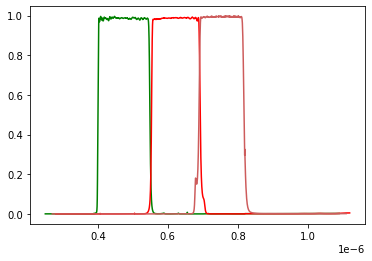

In [41]:
def hulst(a,n,wl):
    p = 4*np.pi*a*(n-1)/wl
    return 2 - ((4/p)*np.sin(p)) + (4/(p**2)*(1-np.cos(p)))

def num_int(h, w, trans):
    return np.sum(h*w*trans)

filt = ['gp','rp','ip']
filt_c = {'gp':'g','rp':'r','ip':'indianred'}
filt_trans = {}
for f in filt:
    d = ascii.read("../LCOGT_filters/SDSS."+f+".txt")
    filt_trans[f] = np.array([d["\lambda"],d["[nm]"]])
    filt_trans[f][0] *= 1e-9 #from nm to m

for f in filt:
    plt.plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f])
plt.show()

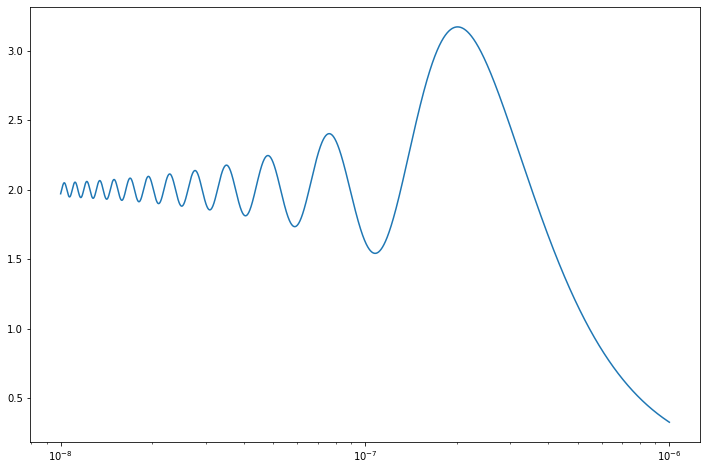

In [50]:
wlarr = np.arange(10,1000,0.01)*1e-9
dsize = 1e-7

plt.figure(figsize=(12,8))
plt.plot(wlarr, hulst(dsize,1.655,wlarr))
plt.xscale('log')

[1.800079e-10 1.799927e-10 1.800079e-10 ... 1.800530e-10 1.799320e-10
 1.800540e-10]


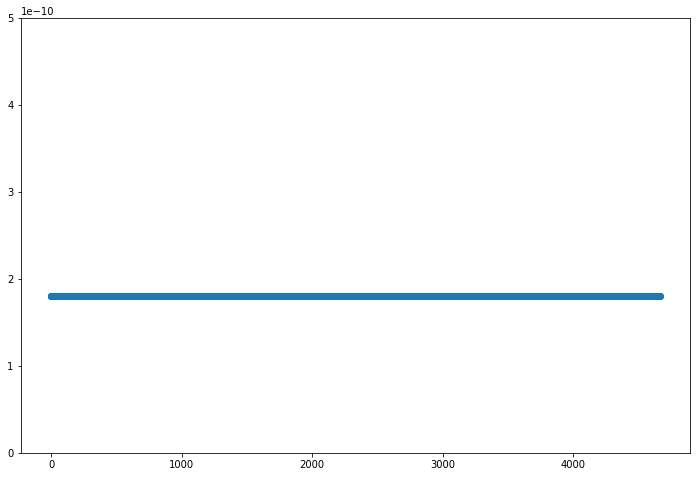

[1.799927e-10 1.799927e-10 1.799927e-10 ... 1.800530e-10 1.799320e-10
 1.800540e-10]


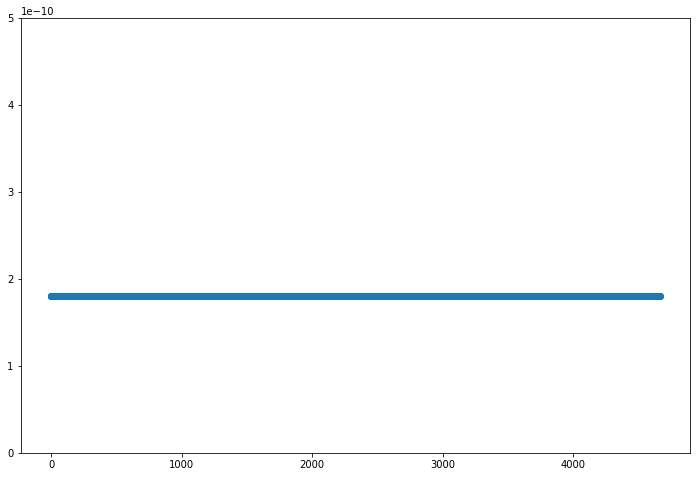

[1.800232e-10 1.799927e-10 1.799927e-10 ... 1.800540e-10 1.800540e-10
 1.799310e-10]


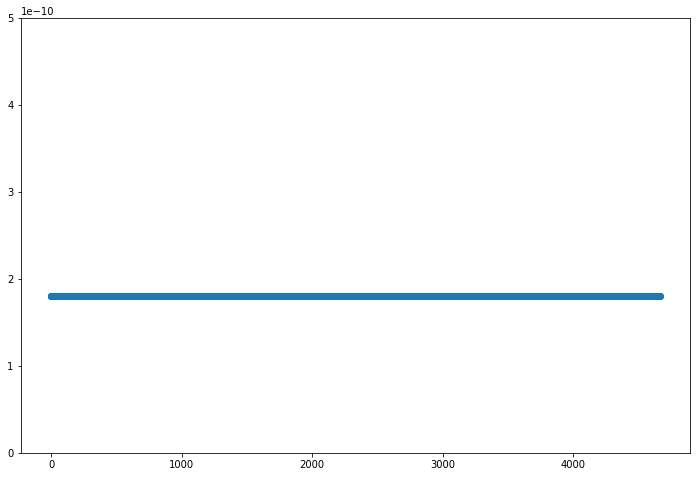

[2.70039978e-07 2.70220001e-07 2.70399994e-07 ... 1.10938001e-06
 1.10956006e-06 1.10973999e-06]


In [42]:
for f in filt:
    plt.figure(figsize=(12,8))
    plt.scatter(np.arange(len(filt_trans[f][0])-1),filt_trans[f][0][1:]-filt_trans[f][0][:-1])
    print (filt_trans[f][0][1:]-filt_trans[f][0][:-1])
    plt.axis(ymin=0,ymax=5e-10)
    plt.show()
print(filt_trans[f][0])

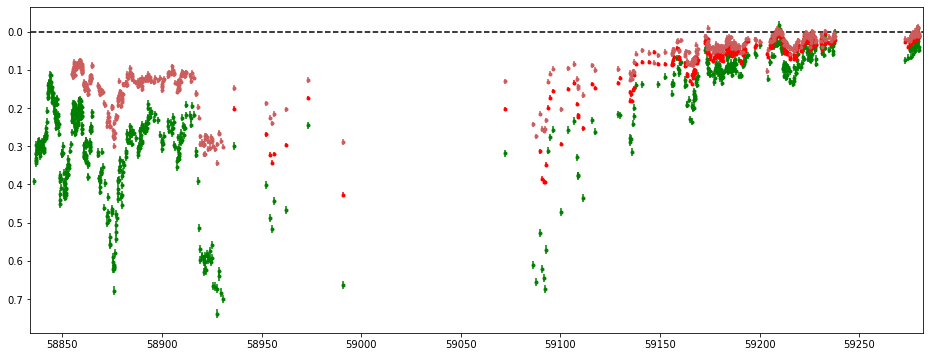

In [43]:
epoch = {}
mag = {}
magerr = {}
for f in filt:
    d = ascii.read('../J0600_mag/LCOGT_'+f+'.txt')
    epoch[f] = np.array(d["EPOCH"])
    mag[f] = np.array(d["NORMMAG"])
    magerr[f] = np.array(d["MAGERR"])

plt.figure(figsize=(16,6))
plt.plot([0,1e6],[0,0],linestyle='--',c='black')
for f in filt:
    plt.errorbar(epoch[f],mag[f],yerr=magerr[f],fmt='.',c=filt_c[f])
plt.xlim(np.min(epoch['gp'])-2,2+np.max(epoch['gp']))
plt.gca().invert_yaxis()
plt.show()


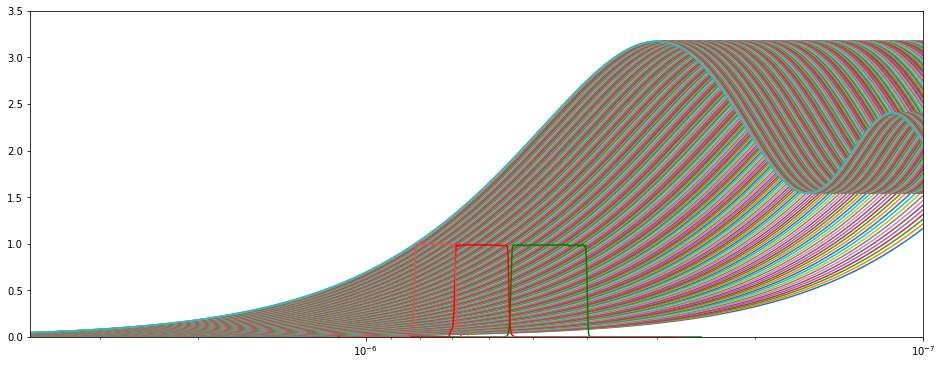

In [44]:
wl_arr = np.arange(100,4000,0.1) * 1e-9 # m
#wl_arr = np.arange(400,860,0.1) * 1e-9 # m

sizes = np.arange(2,15,0.05) * 1e-8 #m
#sizes = [5e-1, 5e-2, 5e-3,5e-4,5e-5,5e-6,5e-7,5e-8]

#fig, axs = plt.subplots(len(sizes), sharex=True, gridspec_kw={'hspace': 0})
#fig.set_figheight(3*len(sizes))
#fig.set_figwidth(16)
#for i in range(len(sizes)):
#    axs[i].plot(wl_arr,hulst(sizes[i],0,wl_arr))
#    for f in filt:
#        axs[i].plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f])
#    axs[i].set_ylim(0,3.5)
#    axs[i].set_yscale('log')
#    axs[i].set_ylim(1e-1,3.5)
#axs[i].set_xscale('log')
#axs[i].set_xlim(np.min(wl_arr),np.max(wl_arr))
#axs[i].invert_xaxis()

# Hide x labels and tick labels for all but bottom plot.
#for ax in axs:
#    ax.label_outer()
#plt.show()

plt.figure(figsize=(16,6))
for s in sizes:
    plt.plot(wl_arr,hulst(s,1.655,wl_arr))
    plt.ylim(0,3.5)
#    axs[i].set_yscale('log')
#    axs[i].set_ylim(1e-1,3.5)
for f in filt:
    plt.plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f])
plt.xscale('log')
plt.xlim(np.min(wl_arr),np.max(wl_arr))
plt.gca().invert_xaxis()

In [45]:
mie_ext = {}
for f in filt:
    tmp = []
    for s in sizes:
        lamb = (filt_trans[f][0][1:]+filt_trans[f][0][:-1])/2
        dlamb = (filt_trans[f][0][1:]-filt_trans[f][0][:-1])
        trans = (filt_trans[f][1][1:]+filt_trans[f][1][:-1])/2
        
        m = num_int(hulst(s,0,lamb),dlamb, trans)
        tmp.append(m)
    mie_ext[f] = np.array(tmp)

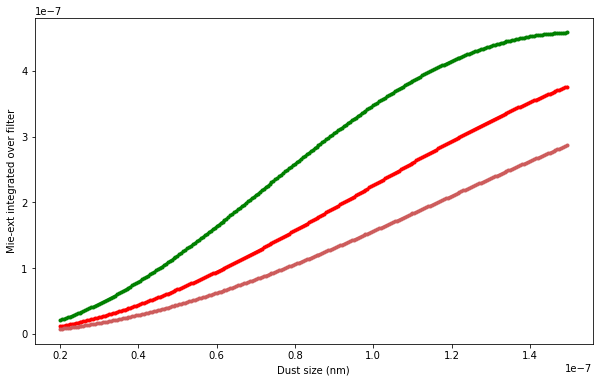

In [36]:
plt.figure(figsize=(10,6))
for f in filt:
    plt.plot(sizes,mie_ext[f],marker='.',c=filt_c[f])
plt.xlabel("Dust size (nm)")
plt.ylabel("Mie-ext integrated over filter")
plt.show()

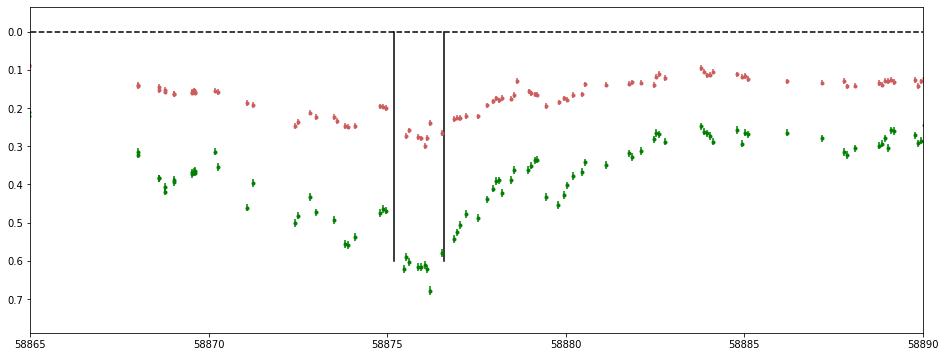

In [37]:
plt.figure(figsize=(16,6))
plt.plot([0,1e6],[0,0],linestyle='--',c='black')
for f in filt:
    plt.errorbar(epoch[f],mag[f],yerr=magerr[f],fmt='.',c=filt_c[f])
plt.xlim(np.min(epoch['gp'])-2,2+np.max(epoch['gp']))
plt.xlim(58865,58890)
#plt.ylim(-0.05,0.25)
for e in [58875.2,58876.6]:
    plt.plot([e,e],[0,.6],c='black')
plt.gca().invert_yaxis()
plt.show()

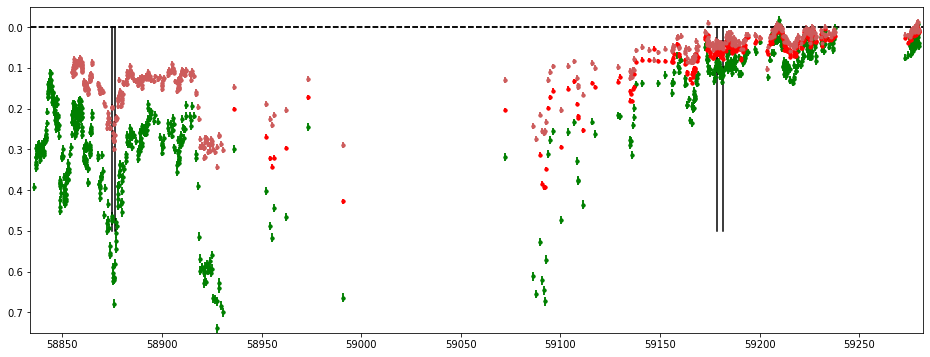

In [38]:
# Select epochs for interesting parts of the lightcurve\

intere = np.array([
    [58875.2,58876.6],
    [59178.5,59181.5]
])
N_e = len(intere[:,0])
point = {}
for f in filt:
    tmp = []
    for i in range(N_e):
        e1, e2 = intere[i]
    
        m1 = epoch[f]>e1
        m2 = epoch[f]<e2
        if np.sum(m1*m2) != 0:
            w = 1/magerr[f][m1*m2]
            tmp.append(np.sum(mag[f][m1*m2]*w)/np.sum(w))
        else:
            tmp.append(np.nan)
    point[f] = np.array(tmp)

plt.figure(figsize=(16,6))
for i in range(N_e):
    e1, e2 = intere[i]
    
    for f in filt:
        plt.plot([e1,e2],[point[f][i]]*2,c=filt_c[f])


    plt.plot([0,1e6],[0,0],linestyle='--',c='black')
    for f in filt:
        plt.errorbar(epoch[f],mag[f],yerr=magerr[f],fmt='.',c=filt_c[f])

    for e in [e1,e2]:
        plt.plot([e,e],[0,.5],c='black')
plt.xlim(np.min(epoch['gp'])-2,2+np.max(epoch['gp']))
#plt.xlim(e1-5,5+e2)
plt.ylim(-0.05,0.75)
plt.gca().invert_yaxis()
plt.show()



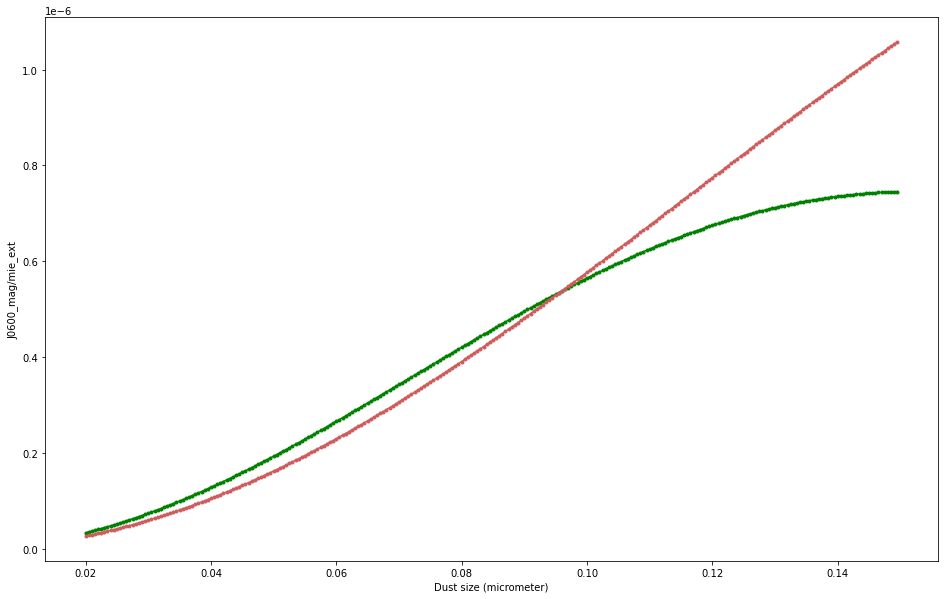

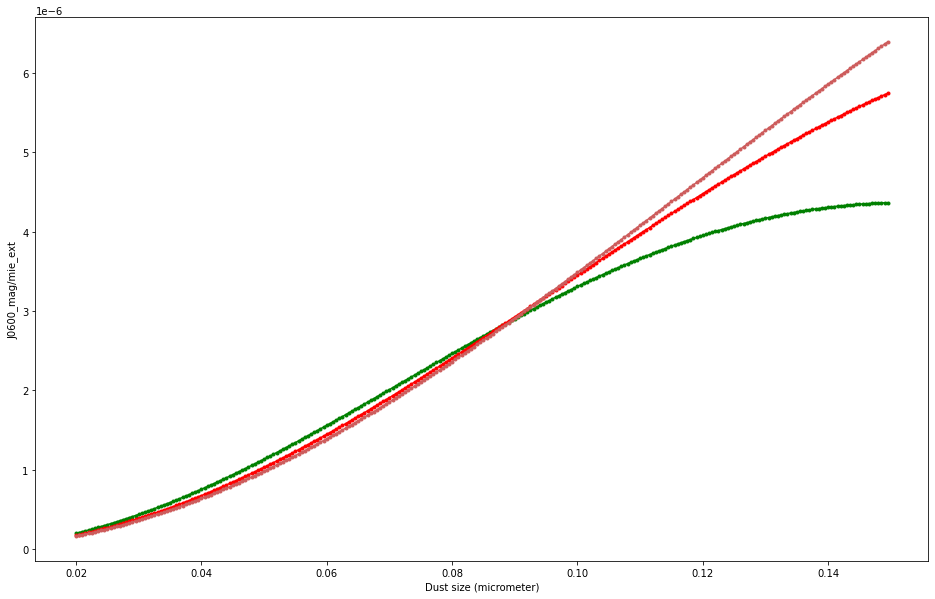

In [39]:
corext = {}
for f in filt:
    corext[f] = []

for i in range(N_e):
    corext_tmp = {}
    for f in filt:
        corext_tmp[f] = mie_ext[f]/point[f][i]
        corext[f].append(corext_tmp[f])

    plt.figure(figsize=(16,10))
    for f in filt:
        plt.plot(sizes*1e6,corext_tmp[f],marker='.',c=filt_c[f])
    plt.xlabel("Dust size (micrometer)")
    plt.ylabel("J0600_mag/mie_ext")
    #plt.show()

for f in filt:
    corext[f] = np.array(corext[f])

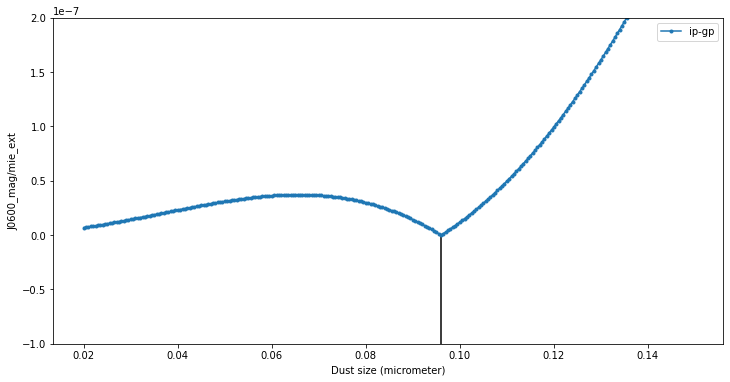

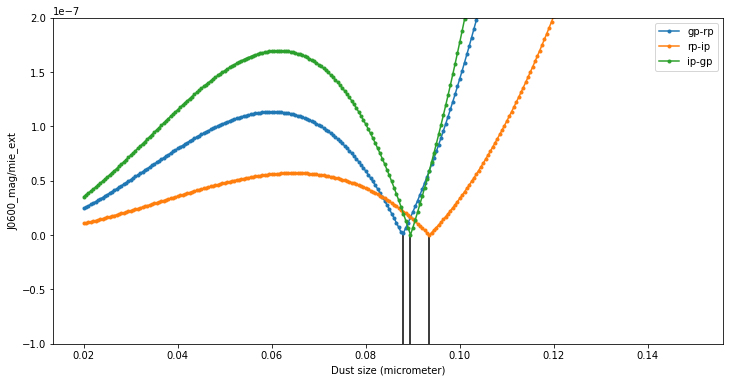

In [40]:
d_size = []


for i in range(N_e):
    plt.figure(figsize=(12,6))
    for f1, f2 in zip(['gp','rp','ip'],['rp','ip','gp']):
        dis = np.abs(corext[f1][i] - corext[f2][i])
        if np.sum(np.isnan(dis)) == 0:
            i_max = np.where(dis == np.min(dis))[0]

            plt.plot([1e6*sizes[i_max]]*2, [0,-1e-7],c='black')
            plt.plot(1e6*sizes,dis,marker='.',label=f1+'-'+f2)

    plt.xlabel("Dust size (micrometer)")
    plt.ylabel("J0600_mag/mie_ext")
    plt.ylim(-1e-7,2e-7)
    plt.legend()
    plt.show()